In [1]:
from dscribe.descriptors import CoulombMatrix
from ase.build import molecule
from ase import Atoms
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

## Dataset stuff

In [30]:
filename = "dsgdb7ae2.xyz"
xyz = open(filename, "r")
lines = xyz.readlines()

In [31]:
mol_id = []
mol_nr_atoms = []
atom_en = []
force_field = []
dft_coord = []
loc_nr_atoms = 0
start = 0
local_list_atoms = []
local_list_numbers = []
global_list_atoms = []
global_list_numbers = []

for i in range(7102):

    nr_atoms = int(lines[loc_nr_atoms])
    mol_nr_atoms.append(nr_atoms)
    
    end = start + nr_atoms + 2
    for row in range(start + 2, end):
        #print(lines[row])
        local_list_atoms.append(lines[row].split()[0])
        local_list_numbers.append([float(x) for x in lines[row].split()[1:7]])
    global_list_atoms.append(local_list_atoms)
    global_list_numbers.append(local_list_numbers)
    
    molecule_id = int(lines[loc_nr_atoms + 1].split()[0])
    mol_id.append(molecule_id)
    
    atomization_energy = float(lines[loc_nr_atoms + 1].split()[1])
    atom_en.append(atomization_energy)
    
    local_list_numbers = []
    local_list_atoms = []
    loc_nr_atoms = row + 1
    start = loc_nr_atoms

## Example on how my lists work

In [32]:
inquired_molecule = 7101                               # 7102 molecules => can be set to 0,1,2,.....,7101
j = inquired_molecule 
print("Molecule id: ", mol_id[j], '\n')
print("Molecule atoms list: ", global_list_atoms[j], '\n')
print("Molecule number of atoms: ", mol_nr_atoms[j], '\n')
print("Molecule atomization energy: ", atom_en[j], '\n')
print("Molecule coordinates: ", global_list_numbers[j])

Molecule id:  7173 

Molecule atoms list:  ['S', 'C', 'N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'] 

Molecule number of atoms:  15 

Molecule atomization energy:  -1459.58 

Molecule coordinates:  [[1.58453, 0.0755, 1.12837, 1.374036, 0.081357, 1.187843], [2.70906, 0.03472, 0.22981, 2.680927, 0.034096, 0.151228], [3.20222, -1.22205, -0.23713, 3.2158, -1.132798, -0.261466], [4.26076, -1.28578, -1.22468, 4.279189, -1.263448, -1.231869], [5.14792, -0.0442, -1.14831, 5.177838, -0.04452, -1.165419], [4.31865, 1.23397, -1.26823, 4.33403, 1.209928, -1.275486], [3.25099, 1.25075, -0.28831, 3.266766, 1.160863, -0.301791], [2.67804, -2.08523, -0.02283, 2.728508, -1.947876, 0.068008], [3.81105, -1.40485, -2.23375, 3.872253, -1.374284, -2.246477], [4.90281, -2.16934, -1.01975, 4.844779, -2.170791, -1.007778], [5.93538, -0.07523, -1.93156, 5.911949, -0.07504, -1.972607], [5.64662, -0.03912, -0.15332, 5.718045, -0.039731, -0.214936], [3.88113, 1.34327, -2.28375, 3.931495, 1.30276

## Ordering on nonH atoms and getting table 3 from the tutorial

In [33]:
list_non_H_atoms = [0, 0, 0, 0, 0, 0, 0]
few_nonH_indices = []
order_few_nonH = []
mol_5 = []
order_mol_5 = []
mol_6 = []
order_mol_6 = []
mol_7 = []
order_mol_7 = []
sorted_molecules_more_nonH = []
order_sorted_molecules_more_nonH = []

for i in range(len(global_list_atoms)):
    no_atoms = len(global_list_atoms[i])
    no_H = global_list_atoms[i].count("H")
    no_nonH = no_atoms - no_H
    #print(no_nonH)
    molecule_index = mol_id[i]                     # index from the file
    molecule_order = i                             # rank of molecule in list
    if no_nonH <= 4:
        few_nonH_indices.append(molecule_index)
        order_few_nonH.append(i)
    elif no_nonH == 5:
        mol_5.append(molecule_index)
        order_mol_5.append(i)
    elif no_nonH == 6:
        mol_6.append(molecule_index)
        order_mol_6.append(i)
    elif no_nonH == 7:
        mol_7.append(molecule_index)
        order_mol_7.append(i)
        
    list_non_H_atoms[no_nonH - 1] = list_non_H_atoms[no_nonH - 1] + 1
    sorted_molecules_more_nonH = mol_5 + mol_6 + mol_7
    order_sorted_molecules_more_nonH = order_mol_5 + order_mol_6 + order_mol_7
    
print("Distribution of molecular size (TABLE 3): ", list_non_H_atoms, '\n')
print("Indices of molecules with 4 or fewer nonH atoms: ", few_nonH_indices, '\n')
print("Number of molecules with 4 or fewer nonH atoms: ", len(few_nonH_indices), '\n')

Distribution of molecular size (TABLE 3):  [1, 3, 12, 43, 157, 935, 5951] 

Indices of molecules with 4 or fewer nonH atoms:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] 

Number of molecules with 4 or fewer nonH atoms:  59 



## Training, prediction and holdout INDICES creation

In [34]:
training_indices = []               # indices here refers to the molecule id 
order_training_indices = []         # order indices here refers to the molecule rank in the ordered list: 0,1,...,7101  ==== 7102 molecules in total
prediction_indices = []
order_prediction_indices = []
holdout_indices = []
order_holdout_indices = []

for i in range(len(sorted_molecules_more_nonH)):
    if i>=7 and i<=7*941 and i%7 == 0:
        training_indices.append(sorted_molecules_more_nonH[i])
        order_training_indices.append(i+59)           #+59 because the first 59 molecules with <=4 nonH atoms come before sorted_molecules_more_nonH
    else:
        prediction_indices.append(sorted_molecules_more_nonH[i])
        order_prediction_indices.append(i+59)

to_pick_from = training_indices
order_to_pick_from = order_training_indices
training_indices = few_nonH_indices + training_indices
order_training_indices = order_few_nonH + order_training_indices

for i in range(100):
    holdout_indices.append(to_pick_from[i*9])
    order_holdout_indices.append(order_to_pick_from[i*9])

training_indices = [x for x in training_indices if x not in holdout_indices]
order_training_indices = [x for x in order_training_indices if x not in  order_holdout_indices]

print("CHECKING DIMENSIONS")
print("Training molecules number: ", len(training_indices), '\n')
print("Prediction molecules number: ", len(prediction_indices), '\n')
print("Holdout molecules number: ", len(holdout_indices))
print("ALL THE FOLLOWING STATEMENTS SHOULD BE FALSE")
print(bool(set(training_indices) & set(prediction_indices)))                          # should be false so lists are disjoint
print(bool(set(training_indices) & set(holdout_indices)))                             # should be false so lists are disjoint
print(bool(set(holdout_indices) & set(prediction_indices)))                           # should be false so lists are disjoint
print("CHECKING DIMENSIONS")
print("Training molecules number: ", len(order_training_indices), '\n')
print("Prediction molecules number: ", len(order_prediction_indices), '\n')
print("Holdout molecules number: ", len(order_holdout_indices))
print("ALL THE FOLLOWING STATEMENTS SHOULD BE FALSE")
print(bool(set(order_training_indices) & set(order_prediction_indices)))               # should be false so lists are disjoint
print(bool(set(order_training_indices) & set(order_holdout_indices)))                  # should be false so lists are disjoint
print(bool(set(order_holdout_indices) & set(order_prediction_indices)))                # should be false so lists are disjoint

CHECKING DIMENSIONS
Training molecules number:  900 

Prediction molecules number:  6102 

Holdout molecules number:  100
ALL THE FOLLOWING STATEMENTS SHOULD BE FALSE
False
False
False
CHECKING DIMENSIONS
Training molecules number:  900 

Prediction molecules number:  6102 

Holdout molecules number:  100
ALL THE FOLLOWING STATEMENTS SHOULD BE FALSE
False
False
False


## Actually building the datasets

In [35]:
cm = CoulombMatrix(
    n_atoms_max = 23,
    permutation = 'sorted_l2',
    flatten = False
    )
species = read("dsgdb7ae2.xyz", index=":")
samples = []

In [36]:
y_training = np.array([atom_en[i] for i in order_training_indices])
#y_training = np.resize(energy_t, (energy_t.shape[0],1))
print("Y training shape: ", y_training.shape)

y_prediction = np.array([atom_en[i] for i in order_prediction_indices])
#y_prediction = np.resize(energy_p, (energy_p.shape[0],1))
print("Y prediction shape: ", y_prediction.shape)

y_holdout = np.array([atom_en[i] for i in order_holdout_indices])
#y_holdout = np.resize(energy_h, (energy_h.shape[0],1))
print("Y holdout shape: ", y_holdout.shape)

Y training shape:  (900,)
Y prediction shape:  (6102,)
Y holdout shape:  (100,)


In [37]:
atoms_t = [species[i] for i in order_training_indices]
matrix_training = cm.create(atoms_t, n_jobs=-1)
print("Matrix for training shape: ", matrix_training.shape)

atoms_p = [species[i] for i in order_prediction_indices]
matrix_prediction = cm.create(atoms_p, n_jobs=-1)
print("Matrix for prediction shape: ", matrix_prediction.shape)

atoms_h = [species[i] for i in order_holdout_indices]
matrix_holdout = cm.create(atoms_h, n_jobs=-1)
print("Matrix for holdout shape: ", matrix_holdout.shape)

Matrix for training shape:  (900, 23, 23)
Matrix for prediction shape:  (6102, 23, 23)
Matrix for holdout shape:  (100, 23, 23)


In [38]:
def array_representation(matrix):
    arrays = []
    for i in range(matrix.shape[0]):
        flattened_array = matrix[i][np.tril_indices(23, k = 0)]
        arrays.append(flattened_array)
    return np.array(arrays)

In [39]:
x_training = array_representation(matrix_training)
print("Final array for training shape: ", x_training.shape)
x_prediction = array_representation(matrix_prediction)
print("Final array for prediction shape: ", x_prediction.shape)
x_holdout = array_representation(matrix_holdout)
print("Final array for holdout shape: ", x_holdout.shape)

Final array for training shape:  (900, 276)
Final array for prediction shape:  (6102, 276)
Final array for holdout shape:  (100, 276)


## Dataset visualization

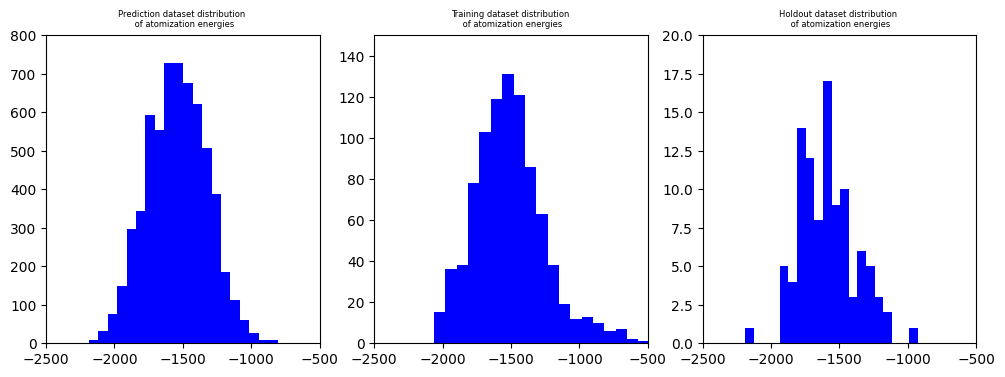

Mean value of atomization energies in prediction dataset: -1539.55 eV
Mean value of atomization energies in training dataset: -1508.76 eV
Mean value of atomization energies in holdout dataset: -1587.07 eV


In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
#fig.suptitle('Horizontally stacked subplots')
ax1.hist(y_prediction, bins=20, density=False, facecolor='blue')
ax1.set_title('Prediction dataset distribution \n of atomization energies', fontsize=6)
ax1.set_xlim([-2500, -500])
ax1.set_ylim([0, 800])
ax2.hist(y_training, bins=20, density=False, facecolor='blue')
ax2.set_title('Training dataset distribution \n of atomization energies', fontsize=6)
ax2.set_xlim([-2500, -500])
ax2.set_ylim([0, 150])
ax3.hist(y_holdout, bins=20, density=False, facecolor='blue')
ax3.set_title('Holdout dataset distribution \n of atomization energies', fontsize=6)
ax3.set_xlim([-2500, -500])
ax3.set_ylim([0, 20])
plt.show()

print("Mean value of atomization energies in prediction dataset: %0.2f eV" %np.mean(y_prediction))
print("Mean value of atomization energies in training dataset: %0.2f eV" %np.mean(y_training))
print("Mean value of atomization energies in holdout dataset: %0.2f eV" %np.mean(y_holdout))

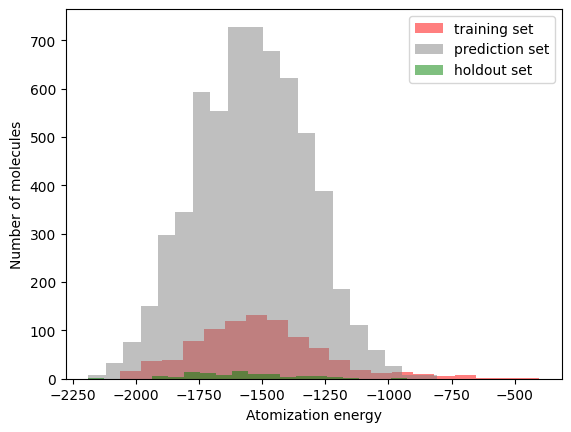

In [41]:
plt.hist(y_training, bins=20, density=False, alpha=0.5, facecolor='red', label='training set')
plt.hist(y_prediction, bins=20, density=False, alpha=0.5, facecolor='gray', label='prediction set')
plt.hist(y_holdout, bins=20, density=False, alpha=0.5, facecolor='green', label='holdout set')
plt.xlabel("Atomization energy")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

## KRR with Gaussian kernel for given hyperparameters

In [42]:
lambda_start = -40
lambda_end = -5
lambda_step_size = 0.5
lambda_samples = int((lambda_end - lambda_start)/lambda_step_size + 1)  #69
lambd = np.logspace(lambda_start, lambda_end, num = lambda_samples, base = 2)

sigma_start = 5
sigma_end = 18
sigma_step_size = 0.5
sigma_samples = int((sigma_end - sigma_start)/sigma_step_size + 1)  #27
sigma = np.logspace(sigma_start, sigma_end, num = sigma_samples, base = 2)


In [43]:
print(x_training.shape)
print(y_training.shape)

(900, 276)
(900,)


In [44]:
cv_number = 3
kernel = 'rbf'
scoring_function = 'neg_mean_absolute_error'


grid_search = GridSearchCV(KernelRidge(), 
                           [{'kernel':[kernel],'alpha': lambd, 'gamma': sigma}], 
                           cv = cv_number, 
                           scoring = scoring_function,
                           verbose = 1,
                           n_jobs = -1)
grid_search.fit(x_training, y_training)

Fitting 3 folds for each of 1917 candidates, totalling 5751 fits


GridSearchCV(cv=3, estimator=KernelRidge(), n_jobs=-1,
             param_grid=[{'alpha': array([9.09494702e-13, 1.28621974e-12, 1.81898940e-12, 2.57243948e-12,
       3.63797881e-12, 5.14487897e-12, 7.27595761e-12, 1.02897579e-11,
       1.45519152e-11, 2.05795159e-11, 2.91038305e-11, 4.11590317e-11,
       5.82076609e-11, 8.23180635e-11, 1.16415322e-10, 1.64636127e-10,
       2.32830644e-10, 3.29272254e-10,...
       5.12000000e+02, 7.24077344e+02, 1.02400000e+03, 1.44815469e+03,
       2.04800000e+03, 2.89630938e+03, 4.09600000e+03, 5.79261875e+03,
       8.19200000e+03, 1.15852375e+04, 1.63840000e+04, 2.31704750e+04,
       3.27680000e+04, 4.63409500e+04, 6.55360000e+04, 9.26819000e+04,
       1.31072000e+05, 1.85363800e+05, 2.62144000e+05]),
                          'kernel': ['rbf']}],
             scoring='neg_mean_absolute_error', verbose=1)

Mean absolute error on test set: 1539.337 eV


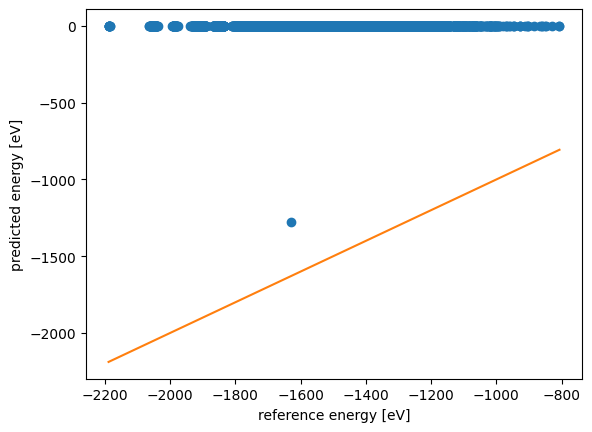

R^2 score on test set: -50.426


In [48]:
y_pred = grid_search.predict(x_prediction) # scikit-learn automatically takes the best combination
                                     # of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_prediction)).mean())

# do the regression plot
plt.plot(y_prediction, y_pred, 'o')
plt.plot([np.min(y_prediction),np.max(y_prediction)], [np.min(y_prediction),np.max(y_prediction)], '-')
plt.xlabel('reference energy [eV]')
plt.ylabel('predicted energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_prediction, y_pred))